## Simulating the Heisemberg chain when $N>2$ 
We can use Qiskit to have a classical simulation of the Heisenberg chain that we will use as a benchmark for the quantum computations.

In [5]:
from numpy import linspace, pi, abs, array, kron, zeros_like, real
from matplotlib.pyplot import plot, xlabel, ylabel, title, grid, show, legend
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.opflow import CircuitSampler, PauliSumOp, StateFn, One, Zero, I, Z
from qiskit.opflow.state_fns import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.quantum_info import SparsePauliOp
from scipy.linalg import expm
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False)

In [6]:
 def HXXX(n):
    '''
    Matrix representation of the XXX Heisenberg model with `n` number of spin 1/2 particles.
    '''   
    # Using `SparsePauliOp` from `Terra` is very compact
    XXs = SparsePauliOp.from_sparse_list([["XX", [i, i + 1], 1] for i in range(n - 1)], n)
    YYs = SparsePauliOp.from_sparse_list([["YY", [i, i + 1], 1] for i in range(n - 1)], n)
    ZZs = SparsePauliOp.from_sparse_list([["ZZ", [i, i + 1], 1] for i in range(n - 1)], n)
    H = XXs + YYs + ZZs # Sum interactions

    return H # Return Hamiltonian

In [7]:
def UXXX(n, t):
    '''
    Unitary evolution operator  with `n` number of spin 1/2 particles.
    '''
    # Using `PauliSumOp` for future compatibility
    H = PauliSumOp(HXXX(n)) # Compute XXX Hamiltonian 
    
    return (t * H).exp_i() # Return the exponential of `-i` times `t` multipled Hamiltonian 

Now that we have the time evolution operator we can apply it to an inital state of choice and study its time dependent properties. 

We consider a system of $N=3$ spins with the initial state $|\psi_0 \rangle = |110\rangle$ and evolve it up until total time $T=\pi$ (rotation angle of the parametric gates).

We will measure the overlap (between the initial state and the state at time $t$) with the initial state at every time $t$, namely $O(t) = |\langle110|U(t)|110\rangle|^2$.

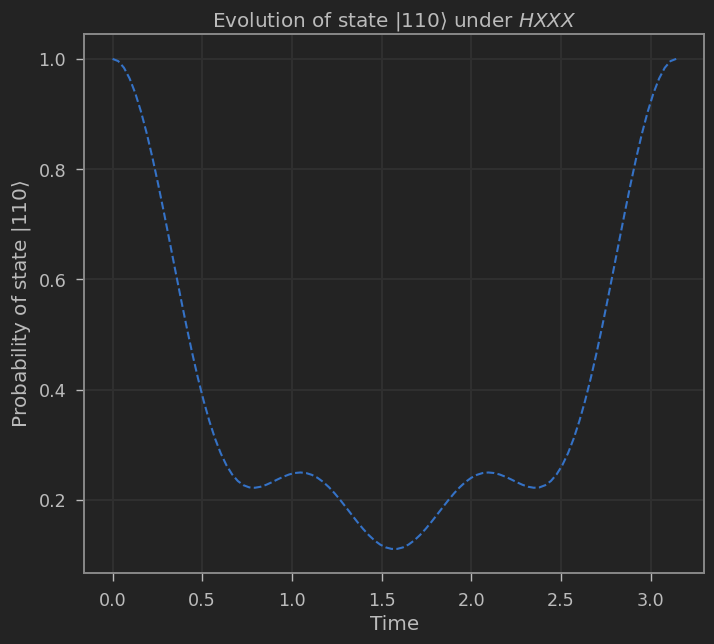

In [8]:
# Define array of time points
time = linspace(0, pi, 100)
number = 3

# Define initial state |110>
initial_state = One ^ One ^ Zero

# Compute probability of remaining in |110> state over the array of time points:
#  - `~initial_state` gives the bra of the initial state (<110|)
#  - `t` needs to be wrapped with `float(t)` to avoid a bug
#  - `eval()` returns the inner product <110|U(t)|110>
probability = [abs((~initial_state @ UXXX(number, float(t)) @ \
                    initial_state).eval()) ** 2 for t in time]

# Plot evolution of |110>
plot(time, probability, '--b')
xlabel('Time')
ylabel(r'Probability of state $|110\rangle$')
title(r'Evolution of state $|110\rangle$ under $HXXX$')
grid()
show()

### Quantum simulation

Now we will study the more general case. 

Actually, we just need to add a spin to see the difference from the $N=2$ case: the exponential $U_{\text{Heis3}}(t)$ cannot be split into a product of simpler exponentials. 
However, we can approximate $U_{\text{Heis3}}(t)$ as a product of simpler exponentials through Trotterization. 
Consider again the 2 spin case, within the larger 3 spin system. 
As we have seen the Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) is $H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. 
Rewritting $U_{\text{Heis3}}(t)$ in terms of the two possible subsystems within the total $N=3$ system you will simulate,

$$
U_{\text{Heis3}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right].
$$

$H^{(0,1)}_{\text{Heis2}}$ and $H^{(1,2)}_{\text{Heis2}}$ do not commute, so $U_{\text{Heis3}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{Heis2}}\right) \exp\left(-i t H^{(1,2)}_{\text{Heis2}} \right)$.
But, this product decomposition can be approximated with Trotterization which says $U_{\text{Heis3}}(t)$ is approximately a short evolution of $H^{(0,1)}_{\text{Heis2}}$ (time = $t/n$) and followed by a short evolution of $H^{(1,2)}_{\text{Heis2}}$ (time = $t/n$) repeated $n$ times

$$
\begin{align}
U_{\text{Heis3}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n.
\end{align}
$$

$n$ is the number of Trotter steps, and as $n$ increases, the approximation becomes more accurate. (Note that how a untiary is split up into subsystems for Trotterization is not necessarily unique.) 

In [9]:
# Here we introduce a general function for Heisenberg chain Trotter evolution, the circuit will 
# not contain the initialisation

def trotter(number, steps, time):
    '''
    Circuit implementing Trotterization of the time evolutiom operator for the XXX Heisenberg
    model on `number` spins which is also the number of qubits of the sytem. Moreover, `steps` is
    the number of trotter steps to implement and `time` it the simulation time we are targeting.
    Naively, every Trotter step requires a number `6 * (num_spins - 1)` of CNOTs
    '''
    # Given a target time and a number of Trotter steps, every step will evolve the circuit for a
    # time `step`
    step = time / steps
    register = QuantumRegister(number) # Initialize quantum circuit for `number`
    circuit = QuantumCircuit(register) # A `QuantumCircuit` can be without a classical register
    
    for _ in range(steps):
        for i in range(number - 1):
            circuit.rxx(2 * step, i, i + 1)
            circuit.ryy(2 * step, i, i + 1)
            circuit.rzz(2 * step, i, i + 1)

        circuit.barrier() # To separate the different Trotter steps

    return circuit

Now we will use the function created to compare the Trotterization with the exact evolution.

In [11]:
# Simulate the system with a different number of Trotter steps and compare with the matrix 
# exponentiation, we will consider 4, 8 and 12 Trotter steps
trotter_probability = {4:[], 8:[], 12:[]}

# Define where you want to run the circuit
backend = Aer.get_backend("statevector_simulator") # Exact
# backend = QasmSimulator(shots = 8000) # Shots
# backend = QasmSimulator(noise_model = noise_model, shots = 8000) # Noisy

expectation = PauliExpectation() 
sampler = CircuitSampler(backend)

# We want to measure |110><110|
projector = StateFn((1 / 8) * (I - Z) ^ (I - Z) ^ (I + Z), is_measurement = True)

# We loop over different number of Trotter steps
for steps in trotter_probability.keys():
    for t in time:
        # Initialize the circuit
        register = QuantumRegister(3)
        circuit = QuantumCircuit(register)
        circuit.x([1, 2])
    
        # Append the Trotterization
        circuit.append(trotter(3, steps, t), [register[0], register[1], register[2]])
        trotter_expectation = expectation.convert(projector @ StateFn(circuit))
        trotter_sample = sampler.convert(trotter_expectation)
        trotter_probability[steps].append(trotter_sample.eval().real)

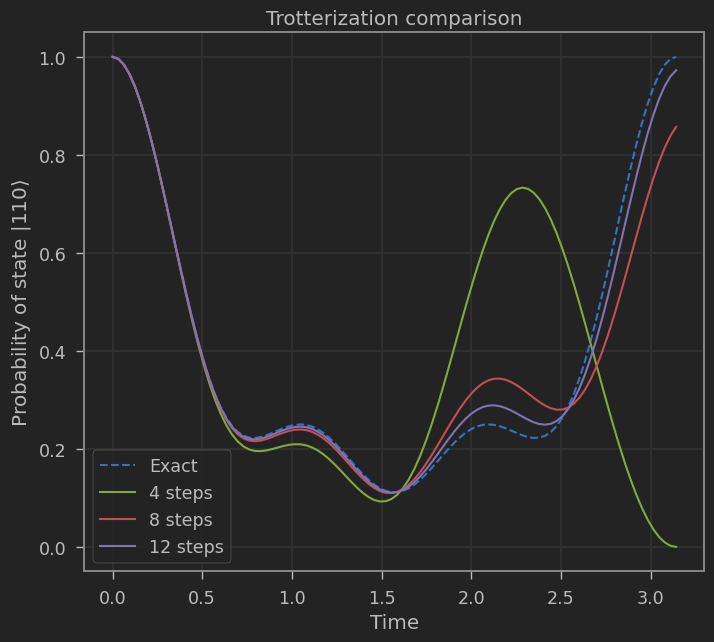

In [12]:
# Now plot the comparison
plot(time, probability, '--', label = "Exact")

for n in trotter_probability.keys():
    plot(time, trotter_probability[n], label = str(n) + " steps")

xlabel('Time')
ylabel(r'Probability of state $|110\rangle$')
title(r'Trotterization comparison')
legend()
grid()
show()

As we can see from the plot , the dynamics gets closer and closer to the exact state evolution as we increase the number of Trotter steps. 

This come at the cost of increasing the number of gates in our quantum circuit.